#Importing Data

https://github.com/nikhilraghava/PyTorch-SVM

In [0]:
# install kaggle to access dataset
!pip install kaggle

In [0]:
# enable kaggle API
# note: you NEED to have your kaggle token saved in drive for this to work (https://github.com/Kaggle/kaggle-api)
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
 from kaggle.api.kaggle_api_extended import KaggleApi
 api = KaggleApi()
 api.authenticate()

In [0]:
# download HASYV2 dataset
api.dataset_download_files('guru001/hasyv2')

In [0]:
# unzip data
!unzip hasyv2.zip

##SVM in Sci-kit learn

In [0]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split

from skimage.io import imread
from skimage.transform import resize

##Train test split

In [0]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms
import numpy as np
from torch import nn

In [0]:
# creating own DatasetClass (this is like an ImageFolder, except custom so that we don't have to arrange images in a directory by label)
class SymbolsDataset(Dataset):
    def __init__(self, labels_path, imgs_path):
        """
        Initialize data set as a list of IDs corresponding to each item of data set
        :param img_dir: path to image files as a uncompressed tar archive
        :param txt_path: a text file containing names of all of images line by line
        """
        # Read in the dataframe
        data = pd.read_csv(labels_path, sep=',', index_col=0)
        
        # Convert the column into a list
        master_list = []
        for i in range(168233):
          master_list.append(data.iloc[i, 1])

        # Extract just the unique values (i.e. the set)
        unique = np.unique(master_list)

        # Create a mapping between each symbol and an ID in [0,...,368]
        dict_id = {}
        i = 0
        for symbol in unique:
          dict_id[symbol] = i
          i = i + 1

        # Add an class_id column to represent the class for each
        data["class_id"] = 0

        # Iterate through the dataframe and add in the new id
        for i in range(168233):
          data.iloc[i, 3] = dict_id[data.iloc[i, 1]]

        # Finally, declare self.df
        self.df = data
        self.img_names = self.df.index.values
        self.labels_path = labels_path
        self.imgs_path = imgs_path
        self.transform = transforms.Compose([transforms.ToTensor()])

    def get_image_from_folder(self, name):
        """
        gets a image by a name gathered from file list text file
        :param name: name of targeted image
        :return: a PIL image
        """
        image = Image.open(os.path.join(self.imgs_path, name))
        return image

    def __len__(self):
        """
        Return the length of data set using list of IDs
        :return: number of samples in data set
        """
        return len(self.img_names)

    def __getitem__(self, index):
        """
        Generate one item of data set. 
        """
        img = self.get_image_from_folder(self.img_names[index])
        img = img.convert('L') # monochrome
        img = self.transform(img)
        #img = np.squeeze(img)
        #lbl = self.df.iloc[index][1]
        lbl = torch.tensor(self.df.iloc[index][3])

        return (img, lbl)

In [0]:
imgs_path = 'hasyv2/'
labels_path = 'hasyv2/hasy-data-labels.csv'

In [0]:
# Create dataset instance
HASYv2 = SymbolsDataset(labels_path, imgs_path)

In [0]:
HASYv2.df

,symbol_id,latex,user_id,class_id
path,,,,
hasy-data/v2-00000.png,31,A,50,15
hasy-data/v2-00001.png,31,A,10,15
hasy-data/v2-00002.png,31,A,43,15
hasy-data/v2-00003.png,31,A,43,15
hasy-data/v2-00004.png,31,A,4435,15
...,...,...,...,...
hasy-data/v2-168228.png,1400,\guillemotleft,16925,143
hasy-data/v2-168229.png,1400,\guillemotleft,16925,143
hasy-data/v2-168230.png,1400,\guillemotleft,16925,143


In [0]:
# create data_loader
data_loader = torch.utils.data.DataLoader(HASYv2,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=1)

In [0]:
# display test images
# stolen from tutorial 3b
def show20(data):
    plt.figure(figsize=(10,2))
    for n, (img, label) in enumerate(data):
        if n >= 20:
            break
        plt.subplot(2, 10, n+1)
        # print(img.shape)
        img = np.squeeze(img)
        plt.imshow(img)

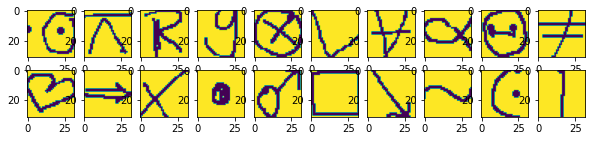

In [0]:
show20(data_loader)

In [0]:
len(HASYv2)

168233

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

# hyperparameters: update batch size, test/validation split
batch_size = 1000
test_val_split = 0.2

# Creating data indices for training and validation splits:
dataset_size = len(HASYv2)
indices = list(range(dataset_size))
split = int(np.floor(test_val_split * dataset_size))

np.random.seed(3)
np.random.shuffle(indices)

test_indices, val_indices, train_indices = indices[:split], indices[split:2*split], indices[2*split:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(HASYv2, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(HASYv2, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(HASYv2, batch_size=batch_size,
                                                sampler=test_sampler)

In [0]:
len(test_indices) + len(train_indices) + len(val_indices)

168233

In [0]:
print("training size: " + str(len(train_indices)))
print("validation size: " + str(len(val_indices)))
print("test size: " + str(len(test_indices)))

training size: 100941
validation size: 33646
test size: 33646


##Training and get_accuracy functions

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
# hyperparameters: update batch size, test/validation split
batch_size_dumb = 10
test_val_split_dumb = 0.2

# Creating data indices for training and validation splits:
dataset_size_dumb = 50
indices_dumb = list(range(dataset_size_dumb))
split_dumb = int(np.floor(test_val_split_dumb * dataset_size_dumb))

np.random.seed(3)
np.random.shuffle(indices_dumb)

test_indices_dumb, val_indices_dumb, train_indices_dumb = indices_dumb[:split_dumb], indices_dumb[split_dumb:2*split_dumb], indices_dumb[2*split_dumb:]

# Creating PT data samplers and loaders:
train_sampler_dumb = SubsetRandomSampler(train_indices_dumb)
valid_sampler_dumb = SubsetRandomSampler(val_indices_dumb)
test_sampler_dumb = SubsetRandomSampler(test_indices_dumb)

train_loader_dumb = torch.utils.data.DataLoader(HASYv2, batch_size=batch_size_dumb, 
                                           sampler=train_sampler_dumb)
validation_loader_dumb = torch.utils.data.DataLoader(HASYv2, batch_size=batch_size_dumb,
                                                sampler=valid_sampler_dumb)
test_loader_dumb = torch.utils.data.DataLoader(HASYv2, batch_size=batch_size_dumb,
                                                sampler=test_sampler_dumb)

In [0]:
for img, labels in iter(train_loader_dumb):
  print(labels)

tensor([17, 18, 15, 17, 16, 16, 15, 17, 16, 17])
tensor([15, 15, 15, 15, 15, 15, 15, 17, 18, 16])
tensor([17, 15, 15, 16, 17, 15, 17, 17, 18, 15])


In [0]:
for img, labels in iter(validation_loader_dumb):
  print(labels)

tensor([16, 15, 15, 15, 15, 17, 17, 16, 17, 15])


In [0]:
for img, labels in iter(test_loader_dumb):
  print(labels)

tensor([18, 17, 18, 15, 16, 15, 15, 18, 15, 17])


In [0]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [0]:
# Implement function for getting model accuracy

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [0]:
# Define the training function

def train(model, train_loader, valid_loader, num_epochs=10, learning_rate=1e-3):

    torch.manual_seed(21)
    # Use cross-entropy loss for this multi-class classification task
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Declare arrays to store accuracy measures
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    # Below, we will track accuracy and loss on a per iteration basis

    print("Training started...")
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        i = 0

        for imgs, labels in iter(train_loader):

            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
              
            #print(imgs.shape)
            out = model(imgs)             # forward pass 
            #print(labels)   
            #print(out)      
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            i = i + 1

            total_train_loss = total_train_loss + loss.item()

        # Compute the average train loss for this epoch
        avg_train_loss = total_train_loss/i

        # Add this avg loss to the tracker
        train_loss.append(avg_train_loss)

        j = 0
        # Compute loss validation set as well
        for imgs, labels in iter(valid_loader):
            
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)
            loss = criterion(out, labels)
            j = j + 1

            total_val_loss = total_val_loss + loss.item()

        # Compute the average validation loss for this epoch
        avg_val_loss = total_val_loss/j

        # Add this avg loss to the tracker
        val_loss.append(avg_val_loss)

        # Report the losses
        print('Epoch #{}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, float(avg_train_loss), float(avg_val_loss)))

        # Store the accuracies for this epoch
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, valid_loader))
        print("Epoch #{}, Training Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, train_acc[-1], val_acc[-1]))

        # Save the model every 3 epochs
        if epoch%3 == 0:
          model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
          torch.save(model.state_dict(), model_path)

    epoch_set = range(num_epochs)

    plt.title("Training vs. Validation Accuracy")
    plt.plot(epoch_set, train_acc, label="Train")
    plt.plot(epoch_set, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Training vs. Validation Loss")
    plt.plot(epoch_set, train_loss, label="Train")
    plt.plot(epoch_set, val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()  

##Model

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

#Support Vector Machine (SVM) is a subclass of the nn.Module class and to initialize our SVM

class SVM(nn.Module):
    """
    Linear Support Vector Machine
    -----------------------------
    This SVM is a subclass of the PyTorch nn module that
    implements the Linear  function. The  size  of  each 
    input sample is 2 and output sample  is 1.
    """
    def __init__(self):
        super(SVM, self).__init__()# Call the init function of nn.Module
        self.name = "SVM_model"
        self.fully_connected = nn.Linear(64 * 4 * 4, 369)  # Implement the Linear function
        
#Forward function applies a linear transformation to the incoming data: y = Ax + b.
    def forward(self, x):
        x = x.view(x.size(0), -1)
        fwd = self.fully_connected(x)  # Forward pass
        return fwd

In [0]:
SVM_model = SVM()

Training started...
Epoch #0, Training Loss: 5.1005, Validation Loss: 3.5324
Epoch #0, Training Accuracy: 0.3753, Validation Accuracy: 0.3687
Epoch #1, Training Loss: 3.0392, Validation Loss: 2.7657
Epoch #1, Training Accuracy: 0.4762, Validation Accuracy: 0.4591
Epoch #2, Training Loss: 2.5046, Validation Loss: 2.4578
Epoch #2, Training Accuracy: 0.5234, Validation Accuracy: 0.4997
Epoch #3, Training Loss: 2.2358, Validation Loss: 2.2633
Epoch #3, Training Accuracy: 0.5577, Validation Accuracy: 0.5344
Epoch #4, Training Loss: 2.0749, Validation Loss: 2.1550
Epoch #4, Training Accuracy: 0.5689, Validation Accuracy: 0.5394
Epoch #5, Training Loss: 1.9553, Validation Loss: 2.0678
Epoch #5, Training Accuracy: 0.5939, Validation Accuracy: 0.5626
Epoch #6, Training Loss: 1.8712, Validation Loss: 2.0216
Epoch #6, Training Accuracy: 0.6025, Validation Accuracy: 0.5648
Epoch #7, Training Loss: 1.8067, Validation Loss: 1.9830
Epoch #7, Training Accuracy: 0.6138, Validation Accuracy: 0.5734
Epoc

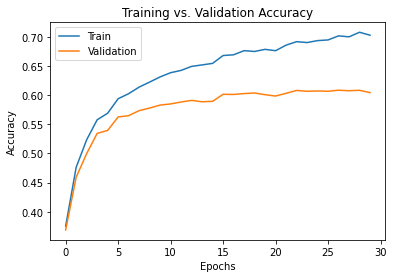

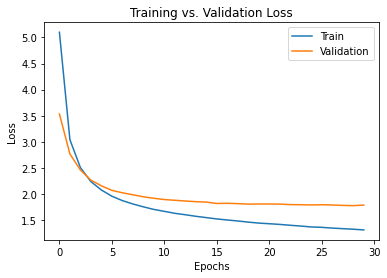

In [0]:
train(SVM_model, train_loader, validation_loader, num_epochs=30, learning_rate=0.001)